# LSTM Model for TCS

In [21]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load datasets
df_tcs = pd.read_csv('/content/drive/MyDrive/TCS.csv', parse_dates=['Date'], index_col='Date')
df_infosys = pd.read_csv('/content/drive/MyDrive/INFY.csv', parse_dates=['Date'], index_col='Date')

# Drop unused columns
df_tcs.drop(columns=['Trades'], inplace=True, errors='ignore')
df_infosys.drop(columns=['Trades'], inplace=True, errors='ignore')

# Clean column names
df_tcs.columns = df_tcs.columns.str.strip()
df_infosys.columns = df_infosys.columns.str.strip()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Load and Prepare Data
close_prices = df_tcs[['Close']].copy()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaled = scaler.fit_transform(close_prices)

In [23]:
# Create Sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(close_scaled, window_size)

In [24]:
# Train-Test Split (80-20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [25]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the Model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0322
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.3952e-04
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 4.4926e-04
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.4796e-04
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 3.3078e-04
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 4.2837e-04
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.4895e-04
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.8830e-04
Epoch 9/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.6634e-04
Epoch 10/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 2.6396e-04
Epoch 11/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.8308e-04
Epoch 12/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.6153e-04
Epoch 13/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.4405e-04
Epoch 14/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 2.

In [28]:
# Make Predictions
y_pred = model.predict(X_test)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [30]:
# Inverse Transform for Evaluation
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

# Evaluation
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)

print("\nLSTM Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


LSTM Model Performance:
MAE: 51.51
MSE: 10887.50
RMSE: 104.34


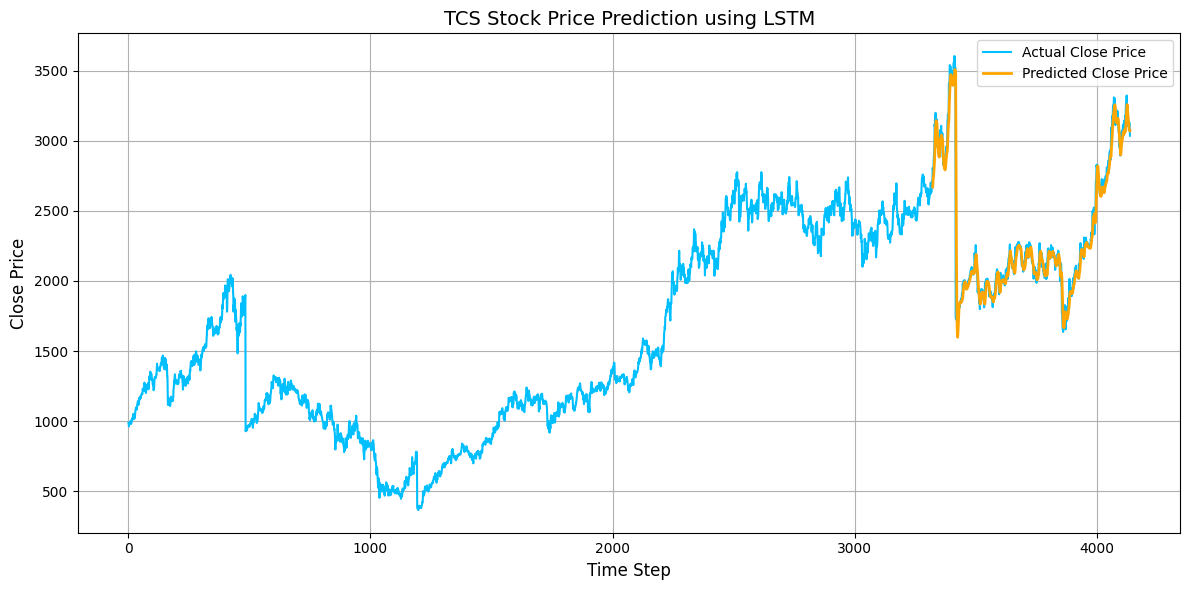

In [31]:
# Plot Forecast-Style
plt.figure(figsize=(12, 6))

# Plot full actual close prices
plt.plot(scaler.inverse_transform(close_scaled), label='Actual Close Price', color='deepskyblue')

# Create empty array for forecast-style plot
pred_plot = np.empty_like(close_scaled)
pred_plot[:, :] = np.nan
pred_plot[len(close_scaled) - len(y_pred_inverse):, :] = y_pred_inverse.reshape(-1, 1)

plt.plot(pred_plot, label='Predicted Close Price', color='orange', linewidth=2)
plt.title("TCS Stock Price Prediction using LSTM", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM Model for Infosys

In [32]:
# Load and Prepare Data
close_prices = df_infosys[['Close']].copy()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaled = scaler.fit_transform(close_prices)

In [33]:
# Create Sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(close_scaled, window_size)

In [34]:
# Train-Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [35]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Train the Model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0050
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.5398e-04
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 2.7422e-04
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.4148e-04
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 2.1068e-04
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.7941e-04
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.4887e-04
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.7278e-04
Epoch 9/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 2.0869e-04
Epoch 10/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.4020e-04
Epoch 11/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.5269e-04
Epoch 12/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.2795e-04
Epoch 13/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.3032e-04
Epoch 14/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 1.

In [38]:
# Make Predictions
y_pred = model.predict(X_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [39]:
# Inverse Transform for Evaluation
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

# Evaluation
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)

print("\nLSTM Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


LSTM Model Performance:
MAE: 18.23
MSE: 1174.39
RMSE: 34.27


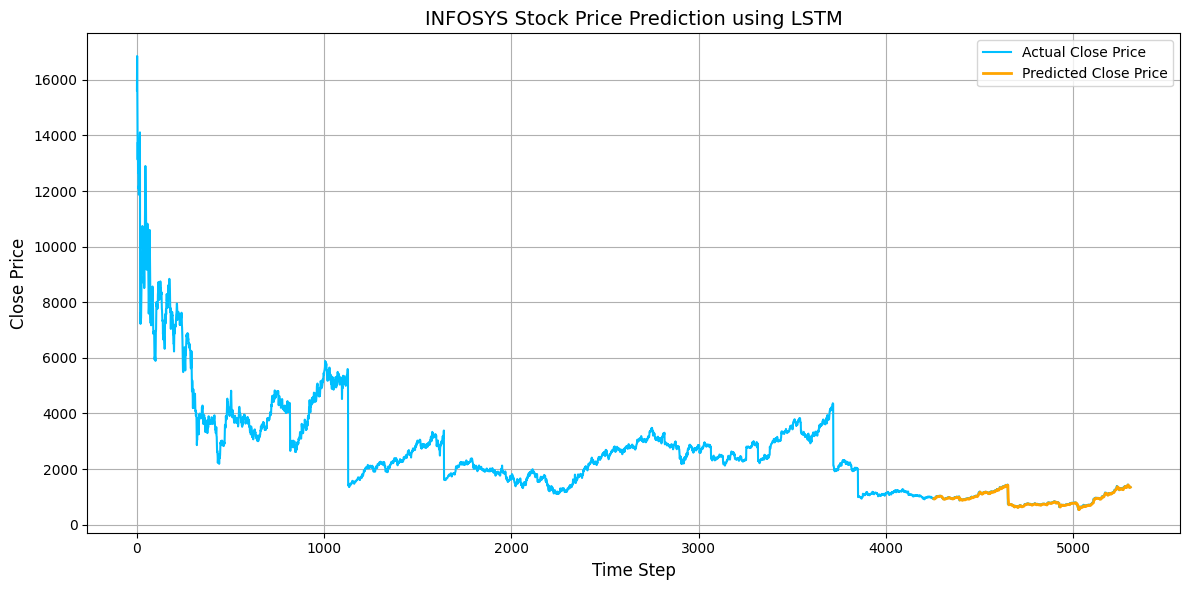

In [40]:
# Plot Forecast-Style
plt.figure(figsize=(12, 6))

# Plot full actual close prices
plt.plot(scaler.inverse_transform(close_scaled), label='Actual Close Price', color='deepskyblue')

# Create empty array for forecast-style plot
pred_plot = np.empty_like(close_scaled)
pred_plot[:, :] = np.nan
pred_plot[len(close_scaled) - len(y_pred_inverse):, :] = y_pred_inverse.reshape(-1, 1)

plt.plot(pred_plot, label='Predicted Close Price', color='orange', linewidth=2)
plt.title("INFOSYS Stock Price Prediction using LSTM", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
